In [1]:
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from msresist.comp_estimator import ComHyperPar, MyOwnKMEANS
from msresist.plsr import ClusterAverages, GridSearch_CV, MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.pre_processing import preprocessing, MergeDfbyMean, FoldChangeFilter
from msresist.sequence_analysis import GeneratingKinaseMotifs
import scipy as sp, numpy as np, pandas as pd, math
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns; sns.set(color_codes=True)
from FileExporter import create_download_link
from Bio import SeqIO
import warnings
warnings.simplefilter("ignore")

# Importing and pre-processing data

### Phosphorylation levels of peptides across conditions | X Matrix where peptides = vars and conditions = obs

Preprocessing: Each peptide is mean-centered across conditions, merged, converted to fold-change to the control, and log2-transformed. Data can be merged by raw sequences or mapped motifs.

In [2]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

treatments = A_r.columns[2:]
header = A_r.columns

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=True)

In [3]:
Xf_data = ABC_mc.iloc[:,2:].T
Xf_protnames = list(ABC_mc.iloc[:,1])
Xf_seqs = list(ABC_mc.iloc[:,0])

### Phenotypes

Cell Viability:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/viability.csv')
Y_cv = Y_cv.iloc[:10, 2]

## Phosphopeptides Heat Map

In [5]:
# g = sns.clustermap(Xf_data.iloc[:, 2:].copy().T, method = "average", robust = True)
# g

In [6]:
# Xf.iloc[:, 2:] = np.log2(Xf.iloc[:, 2:].values)
# Xf_data = np.log2(Xf_data.values)

In [7]:
# p = g.dendrogram_row.reordered_ind

Recovering heat map peptides 

In [8]:
# p = g.dendrogram_row.reordered_ind

# hm_prots = []
# for i in p:
#     hm_prots.append(Xf.iloc[i,:])
# hm_prots = pd.DataFrame(hm_prots)

## Cell Viability Measurements

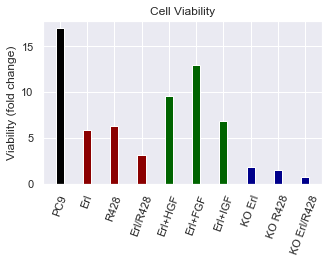

In [9]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.bar(np.linspace(1,10,10)-1, Y_cv,width=0.3,align='center', color=['black', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen', 'darkblue', 'darkblue', 'darkblue'])
plt.xticks(np.arange(10), (treatments), rotation=70)
plt.title("Cell Viability")
plt.ylabel("Viability (fold change)")
# plt.savefig("CellViability.pdf")
plt.show()

# GridSearchCV

Simultaneous hyperparameter tuning of number of clusters and components across entire model pipeline

In [10]:
# import warnings
# warnings.simplefilter("ignore")

# CVresults_max, CVresults_min, best_params = ComHyperPar(Xf_data, Y_cv, Xf_protnames, Xf_seqs)

In [11]:
# print(best_params)
# display(CVresults_min.iloc[:20,:])
# create_download_link(CVresults_min, "GridSearch_ClustVsComp")

In [12]:
# MSE = np.abs(CVresults_min.iloc[:20, 2])
#range_ = np.linspace(1,MSE.shape[0],MSE.shape[0])

#fig, axs = plt.subplots(1,1,figsize=(7,5))
#plt.setp(axs, xticks=range_)
#plt.bar(range_,MSE,width=0.3,align='center', color = "green")
# plt.savefig("GridSearch_Cl&Comp.pdf")
#plt.title("GridSearch Cell Viability")
#plt.xlabel("Number of Components")
#plt.ylabel("MSE")
#plt.show()

# R2Y / Q2Y

Percentages of variance explained (R2Y) and predicted (Q2Y) across numbers of components

In [13]:
import warnings
warnings.simplefilter("ignore")

maxComp = 10
Q2Y = Q2Y_across_components(Xf_data, Y_cv, maxComp+1)
R2Y = R2Y_across_components(Xf_data, Y_cv, maxComp+1)

First using the entire data set

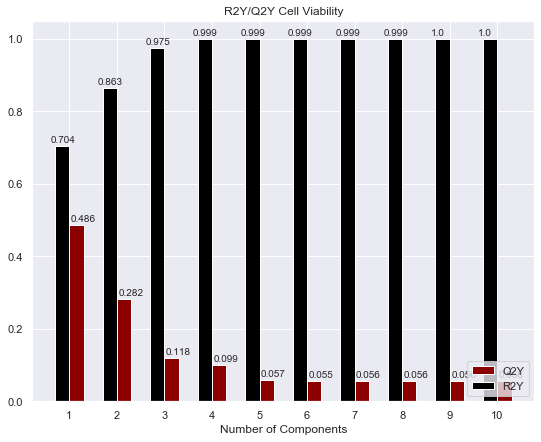

In [14]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.01,3)
disp_values(R2Y,0.6,0.01,3)

Then after k-means clustering setting the number of clusters to 5

In [15]:
kmeans = MyOwnKMEANS(5, Xf_protnames, Xf_seqs).fit(Xf_data, Y=None)
centers = kmeans.transform(Xf_data)
clustermembers = kmeans.ClusterMembers(Xf_data)

In [16]:
maxComp = centers.shape[1]
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp)
R2Y = R2Y_across_components(centers, Y_cv, maxComp)

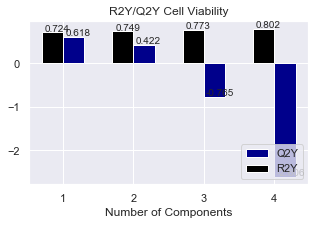

In [17]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp-1,maxComp-1)

fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)
# plt.savefig("R2YQ2Y_BR1_5Cl.pdf")

# Building chained k-means and PLSR model pipeline

## Measured Vs Predicted

We've learnt during cross-validation that by setting the number of components to 2 and the number of clusters to 5 the model should perform reasonably well at predicting the viability response across conditions. To corroborate that we plot measured vs predicted below. We also show that the model performs better after clustering than using the entire data set, or even the filtered data set. 

In [18]:
ncl, ncomp = 5, 2
estimators = [('kmeans', MyOwnKMEANS(ncl, Xf_protnames, Xf_seqs)), ('plsr', PLSRegression(ncomp))]
pipe = Pipeline(estimators)

In [19]:
X_scores, Y_scores = pipe.fit_transform(Xf_data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = pipe.named_steps.plsr.x_loadings_[:, 0], pipe.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = pipe.named_steps.plsr.y_loadings_[:, 0], pipe.named_steps.plsr.y_loadings_[:, 1]

### Cross-Validation Strategy 1 - Pipeline:

Pearson's R:  0.7649197413220155 
 p-value:  0.009948781146109219


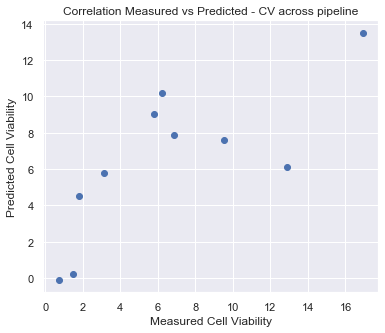

In [20]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(Xf_data,Y_cv, pipe, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
#textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
#props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
#plt.text(0.5, 14.7, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

### Cross-Validation Strategy 2 - Fixed Clusters:

Pearson's R:  0.5859464892344077 
 p-value:  0.07506842174590757


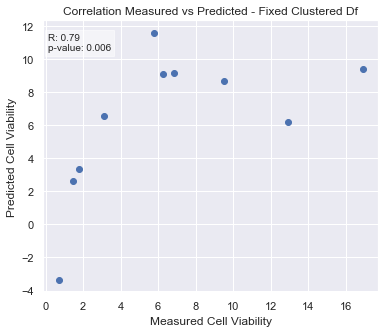

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(Xf_data,Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Df")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
plt.text(0.1, 10.5, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

### Scores and Loadings Plot

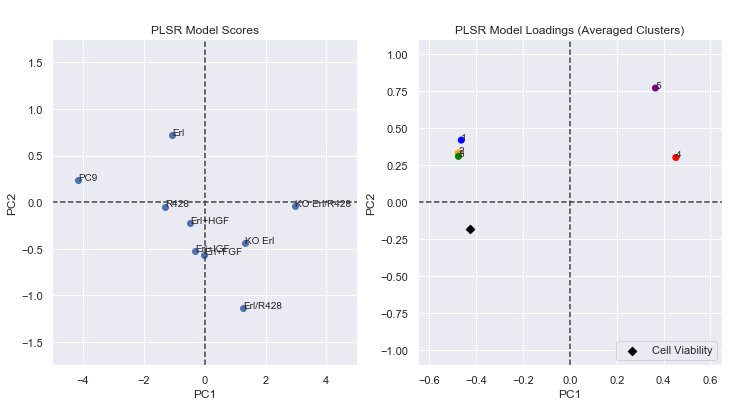

In [22]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
# colors_ = cm.rainbow(np.linspace(0, 1, 5))
colors_ = ["blue", "orange", "green", "red", "purple"]


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-1.75, 1.75])

for i, txt in enumerate(["1", "2", "3", "4", "5"]):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.65, 0.65])
axs[1].set_ylim([-1.1, 1.1])
# plt.savefig('scores_loadings.pdf')
plt.show()

In [23]:
ClusterMembers = pipe.named_steps.kmeans.ClusterMembers(Xf_data)
count = sum(len(v) for v in ClusterMembers.values())
CM_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in ClusterMembers.items() ]))
create_download_link(CM_df, 'fsdf')

In [24]:
CM_df

,1,Seqs_Cluster_1,2,Seqs_Cluster_2,3,Seqs_Cluster_3,4,Seqs_Cluster_4,5,Seqs_Cluster_5
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,Matrin-3,TREPPyRVPRD,Neuroblast differentiation-associated protein ...,KVKGEyDMTVP,Plakophilin-2,GNLHRtSSVPE,Mitogen-activated protein kinase 10,FMMtPyVVTRY
1,MICAL-like protein 1,QADVEyELRCL,Mitogen-activated protein kinase 13,ADAEMtGYVVT,Neuroblast differentiation-associated protein ...,NVKGEyDVTMP,Heterogeneous nuclear ribonucleoprotein U,YSRAKsPQPPV,Mitogen-activated protein kinase 11,TGYVAtRWYRA
2,Kin of IRRE-like protein 1,SHSSGyAQLNT,Lysosomal-associated transmembrane protein 4B,EPPPPyVSA,Plakophilin-3,TSRGQyHTLQA,Heterogeneous nuclear ribonucleoprotein U-like...,DRRGRsPQPPA,Mitogen-activated protein kinase 8,FMMtPyVVTRY
3,Kin of IRRE-like protein 1,SQHSDyGQRFQ,Mitotic interactor and substrate of PLK1,YTGQPsPRGLH,PDZ and LIM domain protein 1,TPPEGyEVVTV,Zinc finger Ran-binding domain-containing prot...,IEREEsDGEYD,Mitogen-activated protein kinase 8,FMMTPyVVTRY
4,Kinesin-like protein KIF20A,LKRSVyIESRI,Myosin light polypeptide 6,GTYEDyVEGLR,PDZ and LIM domain protein 4,LGSEVyRMLRE,Tyrosine-protein kinase SYK,VSFNPyEPELA,La-related protein 1,LIVTQtPHYMR
5,LIM and SH3 domain protein 1,ISNIKyHEEFE,Myosin-9,LDSNLyRIGQS,Palladin,PSASRyAALSD,Twinfilin-2,TAEFLyDEVHP,Kin of IRRE-like protein 1,DPTNGyYNVRA
6,Lethal(2) giant larvae protein homolog 1,CFDPYsDDPRL,Lipoma-preferred partner,NDSDPtYGQQG,Hepatocyte growth factor receptor,KCVAPyPSLLS,Filamin-A,EEVPRsPFKVK,Niban-like protein 1,MDNAVyTFETL
7,Lethal(2) giant larvae protein homolog 1,GCFDPySDDPR,Kinesin light chain 2,AEEVEyYYRRA,Filamin-B,ESVTRsSTETC,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,Osteoclast-stimulating factor 1,TDAVRtLSNAE
8,Lipolysis-stimulated lipoprotein receptor,GGQGSyVPLLR,Lethal(2) giant larvae protein homolog 2,SFDPYsDDPRL,Integrin beta-4,TLTRDyNSLTR,Double-strand break repair protein MRE11,IEVDEsDVEED,G-patch domain and KOW motifs-containing protein,MGPSDtDDD
9,Perilipin-3,ASASEyAHRGL,Lipolysis-stimulated lipoprotein receptor,YAPSTyAHLSP,Thyroid receptor-interacting protein 6,PDRQAyEPPPP,Cyclin-dependent kinase 1,PIRVYtHEVVT,Insulin receptor substrate 2,GDSDQyVLMSS


### Cluster Averages across Conditions

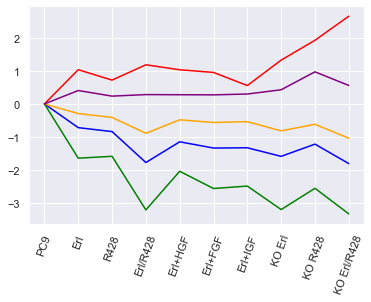

,0,1,2,3,4,5,6,7,8,9
0,0.0,-0.717791,-0.836524,-1.773138,-1.145999,-1.334959,-1.326907,-1.586073,-1.216492,-1.804903
1,0.0,-0.290833,-0.408295,-0.889088,-0.480334,-0.561249,-0.536937,-0.814985,-0.616063,-1.038014
2,0.0,-1.641397,-1.584684,-3.205991,-2.037425,-2.558768,-2.485395,-3.195576,-2.552355,-3.325571
3,0.0,1.035349,0.720369,1.183948,1.033121,0.952396,0.555552,1.324784,1.924581,2.654318
4,0.0,0.405282,0.236079,0.282466,0.278118,0.273964,0.299542,0.428083,0.970535,0.558795


In [25]:
Centers = pipe.named_steps.kmeans.transform(Xf_data)
memb = pipe.named_steps.kmeans.ClusterMembers(Xf_data)


fig = plt.figure(figsize=(6,4))

colors_ = ["blue", "orange", "green", "red", "purple"]

centersT = np.transpose(Centers)
for i in range(centersT.shape[0]):
    plt.plot(centersT[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.xticks(np.arange(centersT.shape[1]), (treatments), rotation=70)
# plt.legend(loc=2, prop={'size':8})
# plt.savefig("ClAvgAcrossCond_BR1.pdf")
plt.show()
display(pd.DataFrame(centersT))